In [1]:
import calliope
import numpy as np
import pandas as pd
import utils_calliope as uc
from datetime import datetime

### Corriendo el modelo

In [2]:
model = calliope.Model("model_config.yml", scenario="ssp245")
model.run()
model.save_commented_model_yaml("combined_ssp245.yml")


/home/aninotna/.conda/envs/calliope_env/lib/python3.11/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.
 * Unrecognised setting in run configuration: save_results

/home/aninotna/.conda/envs/calliope_env/lib/python3.11/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Operational mode requires the same timestep resolution profile to be emulated on each date



In [3]:
ds = model._model_data
# Lista todas las variables en el dataset
print("\n=== Variables en ds ===")
for var in ds.data_vars:
    da = ds[var]
    print(f"{var:25s} dims={da.dims} shape={da.shape}")



=== Variables en ds ===
energy_cap                dims=('loc_techs',) shape=(8,)
carrier_prod              dims=('loc_tech_carriers_prod', 'timesteps') shape=(7, 241)
carrier_con               dims=('loc_tech_carriers_con', 'timesteps') shape=(8, 241)
cost                      dims=('costs', 'loc_techs_cost') shape=(2, 7)
storage_cap               dims=('loc_techs_store',) shape=(1,)
storage                   dims=('loc_techs_store', 'timesteps') shape=(1, 241)
cost_var                  dims=('costs', 'loc_techs_om_cost', 'timesteps') shape=(2, 4, 241)
cost_investment           dims=('costs', 'loc_techs_investment_cost') shape=(2, 6)
unmet_demand              dims=('loc_carriers', 'timesteps') shape=(5, 241)
cost_investment_rhs       dims=('costs', 'loc_techs_cost_investment_constraint') shape=(2, 6)
cost_var_rhs              dims=('costs', 'loc_techs_om_cost', 'timesteps') shape=(2, 4, 241)
system_balance            dims=('loc_carriers_system_balance_constraint', 'timesteps') shape=(

### Resultados de la optimización 

### ¿cuáles son las infraestructuras más relevantes que el modelo decidió instalar en el escenario analizado?

Se consultan los resultados del modelo para identificar qué tecnologías se construyeron y con qué capacidad instalada. 

Para ello, se transforma la variable energy_cap del conjunto de resultados en una serie de pandas, lo que permite ordenarla de mayor a menor y mostrar las diez tecnologías con mayor capacidad. 

In [4]:
ds = model.results

In [5]:
# (A) ¿Qué se construyó? (top-N)
instalado = (ds.energy_cap.to_series()
             .sort_values(ascending=False))
print(instalado.head(10))

loc_techs
VALPO::h2_store           3696.058800
PV_SITE::pv               2000.000000
VALPO::demand_h2          1325.644800
PV_SITE::ac_line:VALPO       2.863095
VALPO::ac_line:PV_SITE       2.863095
VALPO::seawater_supply       2.336793
VALPO::electrolyzer          1.849560
VALPO::desalination          0.734384
Name: energy_cap, dtype: float64


### ¿qué tecnologías concentran la mayor capacidad total instalada en el sistema?

En esta celda se genera un resumen de la capacidad instalada agregada por tipo de tecnología. 

Para ello, se descompone el identificador loc::tech en sus partes (ubicación y tecnología), se agrupan todas las capacidades según la tecnología y luego se suman. Finalmente, se ordenan los resultados de mayor a menor. 

In [7]:
# (B) Capacidad por tipo (resumen)
cap_por_tipo = (ds.energy_cap.to_series()
                .reset_index()
                .assign(location=lambda d: d['loc_techs'].str.split('::').str[0],
                        tech=lambda d: d['loc_techs'].str.split('::').str[1])
                .groupby('tech')['energy_cap'].sum()
                .sort_values(ascending=False))
print(cap_por_tipo)


tech
h2_store           3696.058800
pv                 2000.000000
demand_h2          1325.644800
ac_line:PV_SITE       2.863095
ac_line:VALPO         2.863095
seawater_supply       2.336793
electrolyzer          1.849560
desalination          0.734384
Name: energy_cap, dtype: float64


### ¿cuánto hidrógeno logró abastecer el sistema en el escenario analizado?

Se calcula la demanda total de hidrógeno efectivamente satisfecha en el modelo. 

Primero se seleccionan de los resultados las series de consumo (carrier_con) asociadas específicamente a la demanda de H₂ (demand_h2::hydrogen).

Luego, se revisan algunos valores iniciales para confirmar el signo (en Calliope, el consumo suele registrarse como negativo). Con ese chequeo se ajusta el signo de la serie, de modo que los valores representen energía servida de forma positiva.

Finalmente, se suman todos los pasos temporales para obtener el total de hidrógeno entregado a la demanda, expresado en MWh de H₂.

In [8]:
da_con = ds.carrier_con
labels = da_con['loc_tech_carriers_con'].to_pandas()

mask = labels.str.endswith('::hydrogen') & labels.str.contains('demand_h2')
sel = da_con.sel(loc_tech_carriers_con=labels[mask].tolist())

# Mira algunos valores para confirmar el signo
print(sel.isel(timesteps=slice(0,5)).values)

# Si la mediana es negativa, tomamos el negativo para obtener "servido" positivo
served_ts = sel.sum('loc_tech_carriers_con')  # serie temporal de H2 demandado/servido
sign = np.sign(np.nanmedian(served_ts.values))
h2_served = float((-1 if sign < 0 else 1) * served_ts.sum())

print("H2 servido [MWh_H2]:", h2_served)

[[0. 0. 0. 0. 0.]]
H2 servido [MWh_H2]: 79667499.7644


### ¿cuál es el costo medio de producir y entregar hidrógeno en el escenario simulado?

En esta celda se estima de manera simplificada el costo nivelado del hidrógeno (LCOH). 

Para ello, primero se calcula el costo total del sistema (ds.cost.sum()), luego se divide por la cantidad total de hidrógeno servido (h2_served) para obtener el costo promedio por unidad de energía de hidrógeno en MWh. Finalmente, se convierte ese valor a costo por kilogramo de H₂, usando un factor de conversión aproximado de 33,33 kWh por kg de H₂ (HHV).

El costo nivelado del hidrógeno (LCOH) se calcula como:

$$
\text{LCOH}_{[\$/\text{MWh}_{H_2}]} \;=\; \frac{C_{\text{total}}}{E_{H_2}}
$$

donde:

- \(C_{\text{total}}\) = costo total del sistema (USD)  
- \(E_{H_2}\) = cantidad total de hidrógeno servido (MWh\(_{H_2}\))  

Para expresarlo por kilogramo de hidrógeno:

$$
\text{LCOH}_{[\$/\text{kg}_{H_2}]} \;=\; \frac{\text{LCOH}_{[\$/\text{MWh}_{H_2}]}}{33.33 \;\text{ kWh/kg}}
$$

dado que \(1 \; \text{kg H}_2 \approx 33.33 \; \text{kWh (HHV)}\).


**Nota sobre el factor de conversión (33.33 kWh/kg):**

- 1 kg de hidrógeno contiene aproximadamente **120 MJ de energía** si se considera todo el calor disponible.  
- Como \(1 \; \text{kWh} = 3.6 \; \text{MJ}\), esto equivale a:

  $$
  120 \; \text{MJ} \div 3.6 \; \text{MJ/kWh} \approx 33.3 \; \text{kWh/kg}
  $$

- Este valor corresponde al **HHV (Higher Heating Value)**, es decir, el poder calorífico superior que incluye el calor del vapor de agua al condensarse.  
- En cambio, el **LHV (Lower Heating Value)** excluye ese calor y da un valor menor, alrededor de **30 kWh/kg**.  

En este notebook usamos el valor de **30 kWh/kg (HHV)** como factor de conversión para pasar de MWh a kilogramos de hidrógeno.


In [9]:
# LCOH rápido (costo total / H2 servido)
total_cost = float(ds.cost.sum())
LCOH_MWh = total_cost / h2_served if h2_served > 0 else float('nan')
LCOH_kg  = LCOH_MWh / 30 if h2_served > 0 else float('nan')  # ~33.33 kWh/kg (HHV)
print("LCOH [$ / MWh_H2]:", LCOH_MWh, " | [$ / kg H2]:", LCOH_kg)


LCOH [$ / MWh_H2]: 55.561477190702405  | [$ / kg H2]: 1.85204923969008


### pruebas

In [10]:
import numpy as np
import pandas as pd
from datetime import datetime
import calliope
import utils_calliope as uc

In [11]:
scenarios = ["ssp245", "ssp370", "ssp585"]
rows = []
for sc in scenarios:
    model = calliope.Model("model_config.yml", scenario=sc)
    model.run()
    ds = model._model_data

    # KPIs globales
    kpis = uc.compute_kpis(ds)

    # Rango temporal del modelo
    time_index = pd.to_datetime(ds.timesteps.values)
    timestamp = f"{time_index.min().strftime('%Y-%m-%d')} to {time_index.max().strftime('%Y-%m-%d')}"

    # KPIs por año (se podrían guardar aparte si quieres)
    annual_lcoh = uc.lcoh_per_year(ds)

    rows.append({
        "Scenario": sc,
        "LCOH_$per_MWh": kpis["LCOH_$per_MWh"],
        "LCOH_$per_kg":  kpis["LCOH_$per_kg"],
        "H2_served_MWh": kpis["H2_served_MWh"],
        "Cost_total_$":  kpis["Cost_total_$"],
        "PV_CF_mean":    uc.pv_cf_mean(ds),
        "timestamp":     timestamp,
        "LCOH_annual":   annual_lcoh  # guarda también la tabla anual
    })

df = pd.DataFrame(rows).set_index("Scenario")
print(df[["LCOH_$per_MWh","LCOH_$per_kg","H2_served_MWh","Cost_total_$","PV_CF_mean","timestamp"]])

# Si quieres ver el LCOH por año de cada escenario:
for sc, row in df.iterrows():
    print(f"\n=== {sc} ===")
    print(row["LCOH_annual"][["LCOH_$per_MWh","LCOH_$per_kg"]])

    

/home/aninotna/.conda/envs/calliope_env/lib/python3.11/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.
 * Unrecognised setting in run configuration: save_results

/home/aninotna/.conda/envs/calliope_env/lib/python3.11/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Operational mode requires the same timestep resolution profile to be emulated on each date

/home/aninotna/.conda/envs/calliope_env/lib/python3.11/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the di

          LCOH_$per_MWh  LCOH_$per_kg  H2_served_MWh  Cost_total_$  \
Scenario                                                             
ssp245        55.561477      1.667011   7.966750e+07  4.426444e+09   
ssp370        55.450117      1.663670   7.966750e+07  4.417572e+09   
ssp585        55.923376      1.677869   7.966750e+07  4.455276e+09   

          PV_CF_mean                 timestamp  
Scenario                                        
ssp245      0.861071  2023-01-01 to 2043-01-01  
ssp370      0.862295  2023-01-01 to 2043-01-01  
ssp585      0.873685  2023-01-01 to 2043-01-01  

=== ssp245 ===
            LCOH_$per_MWh  LCOH_$per_kg
2023-12-31       0.198529      0.005956
2024-12-31       0.165175      0.004956
2025-12-31       0.198529      0.005956
2026-12-31       0.198529      0.005956
2027-12-31       0.198529      0.005956
2028-12-31       0.198529      0.005956
2029-12-31       0.198529      0.005956
2030-12-31       0.198529      0.005956
2031-12-31       0.198529   

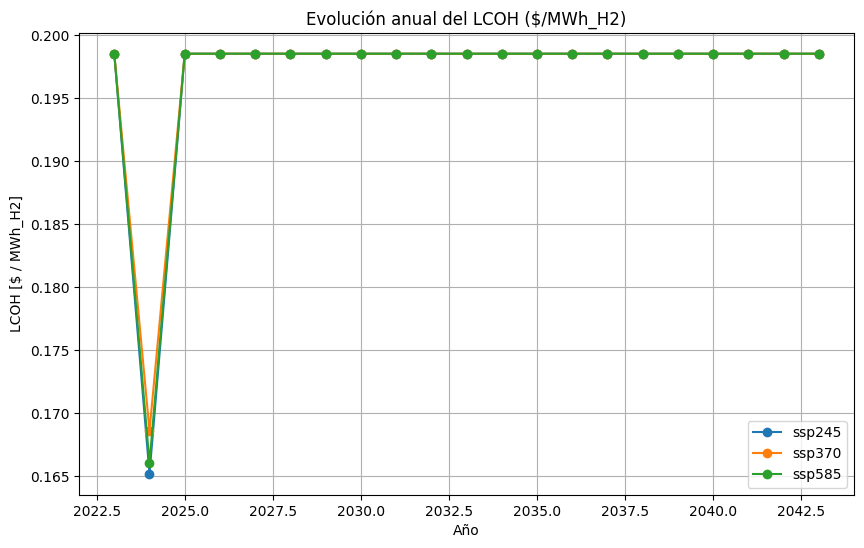

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for sc, row in df.iterrows():
    annual = row["LCOH_annual"]
    plt.plot(
        annual.index.year,
        annual["LCOH_$per_MWh"],
        marker="o",
        label=sc
    )

plt.title("Evolución anual del LCOH ($/MWh_H2)")
plt.xlabel("Año")
plt.ylabel("LCOH [$ / MWh_H2]")
plt.legend()
plt.grid(True)
plt.show()


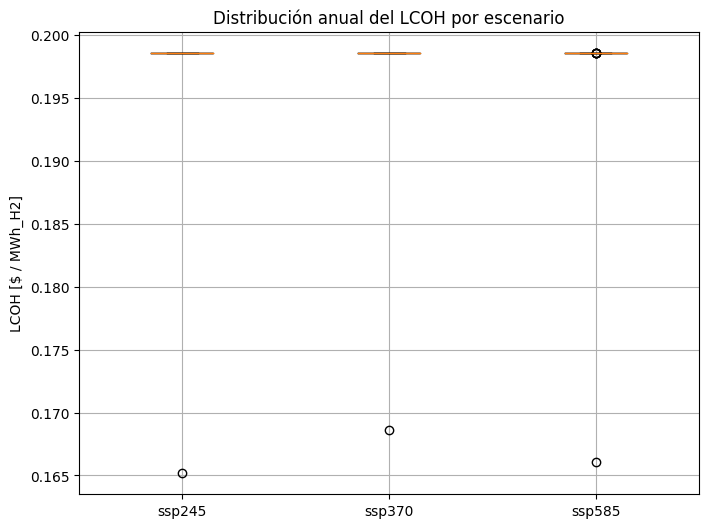

In [13]:
plt.figure(figsize=(8,6))
data = [row["LCOH_annual"]["LCOH_$per_MWh"].values for _, row in df.iterrows()]
plt.boxplot(data, labels=df.index)
plt.title("Distribución anual del LCOH por escenario")
plt.ylabel("LCOH [$ / MWh_H2]")
plt.grid(True)
plt.show()


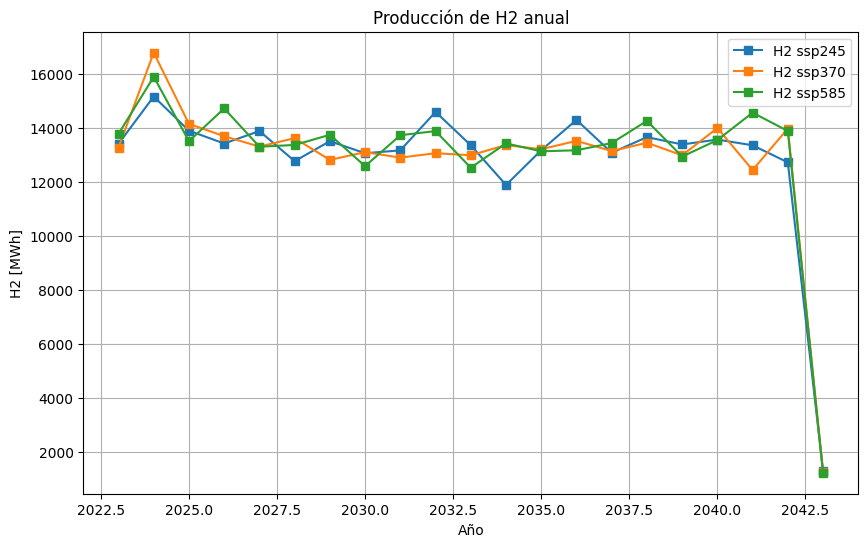

In [14]:
plt.figure(figsize=(10,6))

for sc, row in df.iterrows():
    annual = row["LCOH_annual"]
    plt.plot(
        annual.index.year,
        annual["h2"],
        marker="s",
        label=f"H2 {sc}"
    )

plt.title("Producción de H2 anual")
plt.xlabel("Año")
plt.ylabel("H2 [MWh]")
plt.legend()
plt.grid(True)
plt.show()
